# Evn

In [1]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# 입력 및 Vocab

In [5]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아 나는 오늘 우울해'
]

In [6]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5},
 {0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'})

In [8]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])

# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)

train_inputs

array([[2, 3, 4, 5, 2, 3, 6]])

In [9]:
# embedding
embedding = tf.keras.layers.Embedding(len(word_to_id), 4)

In [10]:
# 단어벡터
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(1, 7, 4), dtype=float32, numpy=
array([[[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292]]],
      dtype=float32)>

# CNN

## padding valid

In [12]:
# CNN (padding valid)
conv_1 = tf.keras.layers.Conv1D(filters=5, kernel_size=3, padding = 'valid') # 기본 값

In [13]:
# CNN 실행
output_1 = conv_1(hidden)
output_1

<tf.Tensor: shape=(1, 5, 5), dtype=float32, numpy=
array([[[ 0.04553854,  0.00398708,  0.0389956 , -0.03502898,
         -0.00369218],
        [ 0.08953248,  0.04308471,  0.03746746,  0.04599547,
         -0.03159672],
        [ 0.00801303, -0.04187064,  0.01202664, -0.01267586,
         -0.00128851],
        [ 0.03558332,  0.04383305,  0.00445943, -0.00553668,
          0.03128533],
        [ 0.0372184 ,  0.02098272,  0.01149326, -0.00155734,
         -0.01826519]]], dtype=float32)>

In [14]:
# weights
weights = conv_1.get_weights()
W = weights[0]
b = weights[1]
print(W.shape) # (kernel_size, input_hidden, filters)
print(b.shape) # (filters, )

(3, 4, 5)
(5,)


## padding causal
kernel size에 따라서 앞에 자동으로 padding(all zero)를 추가해서 길이를 맞춤

In [16]:
# CNN (padding causal)
conv_2 = tf.keras.layers.Conv1D(filters = 5, kernel_size = 3, padding = 'causal')

In [18]:
# CNN 실행
output_2 = conv_2(hidden)
output_2.shape

TensorShape([1, 7, 5])

In [21]:
# weights
weights = conv_2.get_weights()
W = weights[0]
b = weights[1]
print(W.shape) # (kernel_size, input_hidden, filters)
print(b.shape) # (filters, )

(3, 4, 5)
(5,)


## padding same
kernel size에 따라서 앞/뒤에 자동으로 padding(all zero)를 추가해서 길이를 맞춤

In [22]:
# CNN (padding same)
conv_3 = tf.keras.layers.Conv1D(filters = 5, kernel_size = 3, padding = 'same')

In [23]:
# CNN 실행
output_3 = conv_3(hidden)
output_3.shape

TensorShape([1, 7, 5])

In [24]:
# weights
weights = conv_3.get_weights()
W = weights[0]
b = weights[1]
print(W.shape) # (kernel_size, input_hidden, filters)
print(b.shape) # (filters, )

(3, 4, 5)
(5,)


## dilation_rate
kernel이 간격을 두고서 특징을 추출함

In [25]:
# CNN (padding valid, dilation_rate)
conv_4 = tf.keras.layers.Conv1D(filters = 5, kernel_size = 3, padding = 'valid', dilation_rate = 2)

In [26]:
# CNN 실행
output_4 = conv_4(hidden)
output_4.shape

TensorShape([1, 3, 5])

In [27]:
# weights
weights = conv_4.get_weights()
W = weights[0]
b = weights[1]
print(W.shape) # (kernel_size, input_hidden, filters)
print(b.shape) # (filters, )

(3, 4, 5)
(5,)


## CNN 모델

In [36]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    CNN 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    input = tf.keras.layers.Input(shape=(n_seq,))

    embedding = tf.keras.layers.Embedding(n_vocab, d_model)  # (n_vocab x d_model)
    hidden = embedding(input)  # (bs, 1, d_model)

    #############################################
    conv_1 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding = 'causal')
    hidden = conv_1(hidden)
    conv_2 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding = 'valid')
    hidden = conv_2(hidden)
    #############################################

    output = tf.keras.layers.Dense(n_out, activation=tf.nn.softmax)(hidden)  # (bs, 1, n_vocab)

    model = tf.keras.Model(inputs=input, outputs=output)
    return model

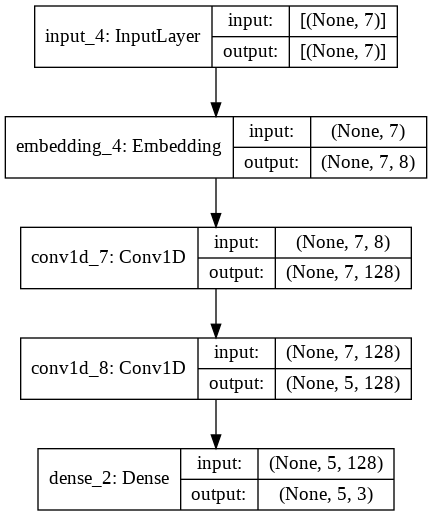

In [37]:
# 모델 생성
model = build_model(len(word_to_id), 8, 7, 3)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [38]:
model.predict(train_inputs)

array([[[0.3386537 , 0.32783797, 0.33350834],
        [0.3307062 , 0.33593437, 0.33335942],
        [0.33216646, 0.33524606, 0.33258745],
        [0.33131513, 0.33143783, 0.33724704],
        [0.33476982, 0.32799274, 0.3372375 ]]], dtype=float32)